In [1]:
%%capture
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math

from scipy import signal
import pandas as pd
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
%run KalmanFilter.ipynb

In [28]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import backend as K 

## Load DataStream and Ground Truth
As no reliable ground truth currently, using Kalman Filter results. Note: Ground truth must currently have the same timesteps as the input.

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration


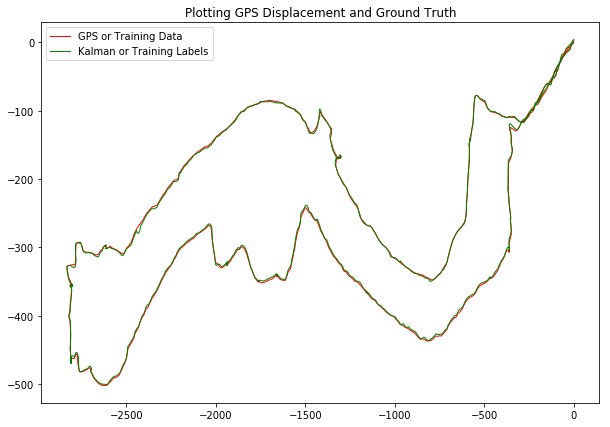

In [3]:
data = Data_Stream('data8.csv')
compute_kalman(data)
plt.figure(figsize=(10, 7))
ax=plt.subplot(111)
plt.plot(data.gps[:, 1], data.gps[:, 2], 'r-', lw=1, label='GPS or Training Data ') ##
plt.plot(data.kal_dis[:, 1], data.kal_dis[:, 2], 'g-', lw=1, label='Kalman or Training Labels') ##Training Labels
plt.title("Plotting GPS Displacement and Ground Truth") 
ax.legend()

### Get input data and correct labels in the right form

Parameter for choosing whether how much of data stream is training/test data

In [4]:
def create_input_and_output(data, just_acc=False):
    ## Needed Data
    gps = data.gps[:, 1:3]
    acc = data.acc_ERC[:, 1:3]
    vel = data.vel_ERC[:, 1:3]
    mag = data.mag[:, 1:3]
    gyro = data.gyro[:, 1:4]

    time_series = data.acc_ERC[:, 0]
    ground_truth = data.kal_dis[:, 1:3]
    delta_time = np.diff(time_series, axis=0, prepend=0.0)


    # Choose which data to include in input
    if (just_acc):
        input_data = np.concatenate((gps, acc, delta_time), axis=1)
    else:
        input_data = np.concatenate((gps, acc, mag, gyro, delta_time), axis=1)
    return input_data, ground_truth

## Split data for training and testing
input_data, ground_truth = create_input_and_output(data)
x_dim = input_data.shape[1]
y_dim = ground_truth.shape[1]
print("X Dim: ", x_dim)

num_train = int(0.70*input_data.shape[0])
num_test = input_data.shape[0] - num_train

training_data   = input_data[:num_train, :]
training_labels = ground_truth[:num_train, :]

test_data     = input_data[num_train:, :]
test_labels   = ground_truth[num_train:, :]

X Dim:  10


### Print Data with Pandas

Training Data


,GPS X,GPS Y,Acc X,Acc Y,Mag X,Mag Y,Gyro X,Gyro Y,Gyro Z,Delta Time,Ground Truth X,Ground_Truth Y
0,0.0,0.0,0.038273,-0.041610,3.427,-30.370,-0.706,-0.610,-0.234,0.00000,0.000000,0.000000
1,0.0,0.0,0.038273,-0.041610,3.427,-30.370,-0.706,-0.610,-0.234,0.02021,0.000008,-0.000008
2,0.0,0.0,0.038273,-0.041610,5.574,-31.047,-0.381,-0.875,-0.097,0.02017,0.000031,-0.000034
3,0.0,0.0,0.038273,-0.041610,4.138,-30.363,-0.045,-1.030,-0.005,0.02018,0.000070,-0.000076
4,0.0,0.0,0.085948,-0.615552,1.968,-30.371,0.098,-0.920,-0.032,0.02017,0.000125,-0.000136


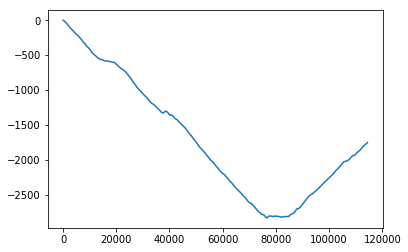

In [5]:
if(False):
    training_frame = pd.DataFrame(np.concatenate((training_data, training_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y', 
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
else:
    training_frame = pd.DataFrame(np.concatenate((training_data, training_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y',
                                                          'Mag X', 'Mag Y',
                                                          'Gyro X', 'Gyro Y', 'Gyro Z',
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
print("Training Data")
display(training_frame.head(5))
training_frame['GPS X'].plot()

In [30]:
if(False):
    test_frame = pd.DataFrame(np.concatenate((test_data, test_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y', 
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
else:
    test_frame = pd.DataFrame(np.concatenate((test_data, test_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y',
                                                          'Mag X', 'Mag Y',
                                                          'Gyro X', 'Gyro Y', 'Gyro Z',
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
print("Testing Data")
display(test_frame.head(5))



Testing Data


,GPS X,GPS Y,Acc X,Acc Y,Mag X,Mag Y,Gyro X,Gyro Y,Gyro Z,Delta Time,Ground Truth X,Ground_Truth Y
0,-1751.386018,-351.361554,0.324140,6.715774,36.841,13.806,0.938,-0.077,-1.186,0.02018,-1752.659613,-348.455156
1,-1751.331459,-351.368101,0.362594,5.108257,39.003,9.659,1.474,1.346,0.113,0.02017,-1752.597046,-348.454252
2,-1751.276900,-351.374648,-3.140174,3.373238,40.460,9.662,2.498,2.507,1.418,0.02017,-1752.534351,-348.451234
3,-1751.222341,-351.381195,-6.380517,1.566248,39.723,6.891,2.245,3.386,2.416,0.02017,-1752.472227,-348.446799
4,-1751.167782,-351.387742,-4.983261,-4.731311,35.805,10.474,0.876,3.065,2.441,0.02017,-1752.412024,-348.441674


### Create Scaling Object to Scale down data to between 0 and 1

In [31]:
x_scaler = MinMaxScaler()
x_scaler.fit(training_data*2)
scaled_training_data = x_scaler.transform(training_data)
scaled_test_data = x_scaler.transform(test_data)

print("Min: ", np.min(training_data), " Max: ", np.max(training_data))
print("Min: ", np.min(scaled_training_data), " Max: ", np.max(scaled_training_data))

print("Min: ", np.min(test_data), " Max: ", np.max(test_data))
print("Min: ", np.min(scaled_test_data), " Max: ", np.max(scaled_test_data))

Min:  -2832.3966927250185  Max:  93.018
Min:  0.0  Max:  1.0
Min:  -1751.3860180391512  Max:  61.626
Min:  0.0950155763124328  Max:  1.0016618657233505


In [8]:
display(pd.DataFrame(input_data).head(5))

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.038273,-0.041610,3.427,-30.370,-0.706,-0.610,-0.234,0.00000
1,0.0,0.0,0.038273,-0.041610,3.427,-30.370,-0.706,-0.610,-0.234,0.02021
2,0.0,0.0,0.038273,-0.041610,5.574,-31.047,-0.381,-0.875,-0.097,0.02017
3,0.0,0.0,0.038273,-0.041610,4.138,-30.363,-0.045,-1.030,-0.005,0.02018
4,0.0,0.0,0.085948,-0.615552,1.968,-30.371,0.098,-0.920,-0.032,0.02017


In [9]:
display(pd.DataFrame(scaled_training_data).head(5))

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.999778,0.580509,0.697973,0.314155,0.380545,0.365377,0.523531,0.585078,0.000000
1,1.0,0.999778,0.580509,0.697973,0.314155,0.380545,0.365377,0.523531,0.585078,0.095393
2,1.0,0.999778,0.580509,0.697973,0.322219,0.377640,0.373784,0.517615,0.589954,0.095204
3,1.0,0.999778,0.580509,0.697973,0.316825,0.380575,0.382476,0.514154,0.593229,0.095252
4,1.0,0.999778,0.581064,0.692190,0.308675,0.380540,0.386175,0.516610,0.592268,0.095204


In [10]:
y_scaler = MinMaxScaler()
y_scaler.fit(ground_truth*2)
scaled_training_labels = y_scaler.transform(training_labels)
scaled_test_labels = y_scaler.transform(test_labels)

print("Min: ", np.min(training_labels), " Max: ", np.max(training_labels))
print("Min: ", np.min(scaled_training_labels), " Max: ", np.max(scaled_training_labels))

print("Min: ", np.min(test_labels), " Max: ", np.max(test_labels))
print("Min: ", np.min(scaled_test_labels), " Max: ", np.max(scaled_test_labels))

Min:  -2833.7539809115074  Max:  0.03379584650008723
Min:  0.4960580058105176  Max:  0.9989645125192248
Min:  -1752.6596134896372  Max:  3.9810852918912762
Min:  0.5598065295433295  Max:  0.9994822292952041


### Define Batch Generator
Data is currently in a form of N observations, with 5/14 input signals and 2 ouput signals. To be processes by tensorflow 
layers, this is converted to batches of sequences of observations

In [11]:
print(scaled_training_data.shape)
print(scaled_training_labels.shape)

(114399, 10)
(114399, 2)


In [12]:
def batch_generator(batch_size, sequence_length):

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, x_dim)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, y_dim)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            rand_start = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = scaled_training_data[rand_start : rand_start + sequence_length]
            y_batch[i] = scaled_training_labels[rand_start : rand_start + sequence_length]
        
        yield (x_batch, y_batch)

In [13]:
batch_size = 256

In [14]:
generator = batch_generator(batch_size=batch_size, sequence_length=100)
x_batch, y_batch = next(generator)

(256, 100, 10)
(256, 100, 2)


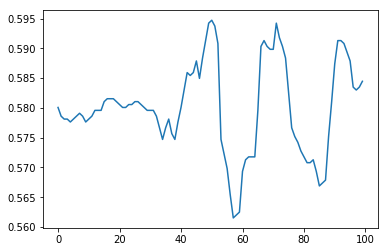

In [15]:
print(x_batch.shape)
print(y_batch.shape) 
batch = 0   # First sequence in the batch.
signal = 2  # Signal, GPS looks like steps as is interpolated at low frequency
seq = x_batch[batch, :, signal]
plt.plot(seq)

In [16]:
validation_data = (np.expand_dims(scaled_test_data, axis=0), np.expand_dims(scaled_test_labels, axis=0))

In [32]:
model = Sequential()
model.add(GRU(units=512, return_sequences=True, input_shape=(None, x_dim,)))#
model.add(Dense(y_dim, activation='sigmoid'))

In [33]:
warmup_steps = 50

In [34]:
def loss_mse_warmup(y_true, y_pred):
    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [35]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 512)         803328    
_________________________________________________________________
dense_2 (Dense)              (None, None, 2)           1026      
Total params: 804,354
Trainable params: 804,354
Non-trainable params: 0
_________________________________________________________________


In [36]:
# path_checkpoint = '23_checkpoint.keras'
# callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
#                                       monitor='val_loss',
#                                       verbose=1,
#                                       save_weights_only=True,
#                                       save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)
# callback_tensorboard = TensorBoard(log_dir='./23_logs/',
#                                    histogram_freq=0,
#                                    write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [callback_early_stopping,
#              callback_checkpoint,
#              callback_tensorboard,
             callback_reduce_lr]

In [ ]:
%%time
model.fit(np.expand_dims(scaled_training_data, axis=0), np.expand_dims(scaled_training_labels, axis=0), epochs=10, 
          batch_size=32, validation_data=validation_data, callbacks=callbacks)
# model.fit_generator(generator=generator,
#                     epochs=20,
#                     steps_per_epoch=100,
#                     validation_data=validation_data,
#                     callbacks=callbacks)

Train on 1 samples, validate on 1 samples
Epoch 1/20


In [23]:
result = model.evaluate(x=np.expand_dims(scaled_test_data, axis=0),
                        y=np.expand_dims(scaled_test_labels, axis=0))
print("loss (test-set):", result)

1/1 [==============================] - 6s 6s/sample - loss: 4.6869e-05
loss (test-set): 4.6868997742421925e-05


In [24]:
def plot_comparison(trial_input, ground_truth_output, start_index, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_index: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    trial_input = x_scaler.transform(trial_input)
#     if train:
#         trial_input = scaled_training_data
#         ground_truth_output = training_labels
#     else:
#         trial_input = scaled_test_data
#         ground_truth_output = test_labels
    
    # End-index for the sequences.
    end_index = start_index + length
    
    trial_input = trial_input[start_index : end_index]
    ground_truth_output = ground_truth_output[start_index : end_index]
    
    # Make 3D
    trial_input = np.expand_dims(trial_input, axis=0)
    
    # Predict output
    predicted_output = model.predict(trial_input)
    
    # The output of the model is between 0 and 1. Inverse rescale to get input
    predicted_output = y_scaler.inverse_transform(predicted_output[0])
    
    for signal in range(ground_truth_output.shape[1]):
        
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the ground truth and Model predicted versions
        plt.plot(ground_truth_output[:, signal], label='true')
        plt.plot(predicted_output[:, signal], label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='red', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel("X Displacement" if signal == 0 else "Y Displacement")
        plt.xlabel("Timestep")
        plt.legend()
        plt.show()
        
#     # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(ground_truth_output[:, 0], ground_truth_output[:, 1], label='true', color = 'g')
#     plt.plot(predicted_output[:warmup_steps, 0], predicted_output[:warmup_steps, 1], label='predicted warmup', color = 'r')
    plt.plot(predicted_output[warmup_steps:, 0], predicted_output[warmup_steps:, 1], label='predicted', color = 'b')
    print(len(predicted_output[warmup_steps:, 0]))
    plt.legend()
    plt.show()
        

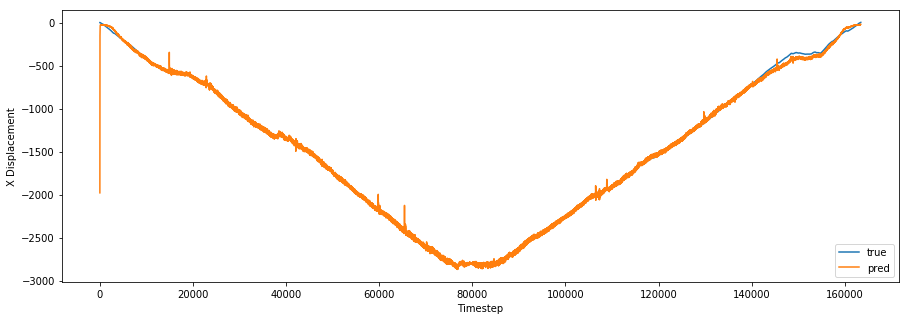

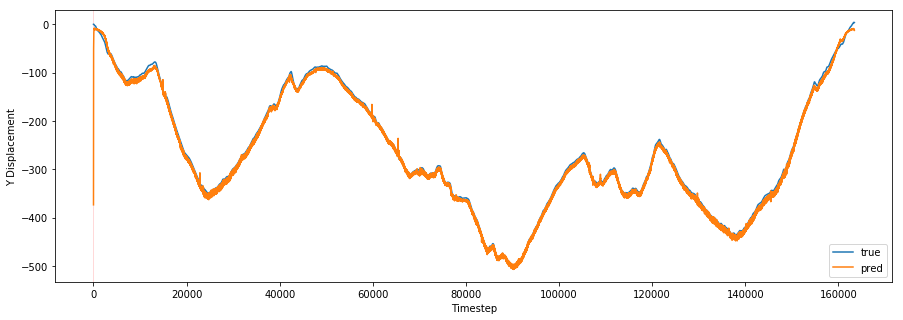

163378


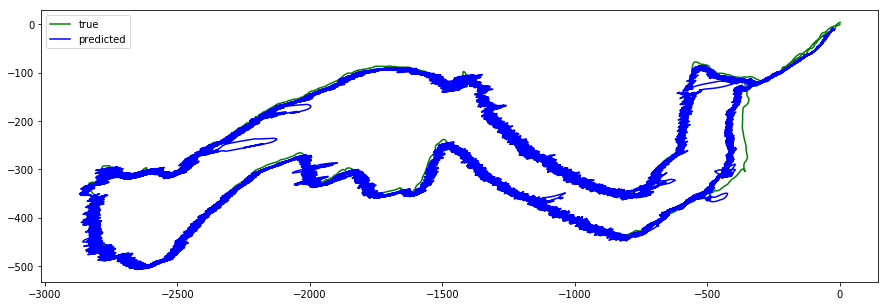

In [25]:
plot_comparison(input_data, ground_truth, start_index=0, length=num_train+num_test, train=True)

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
Data:  1


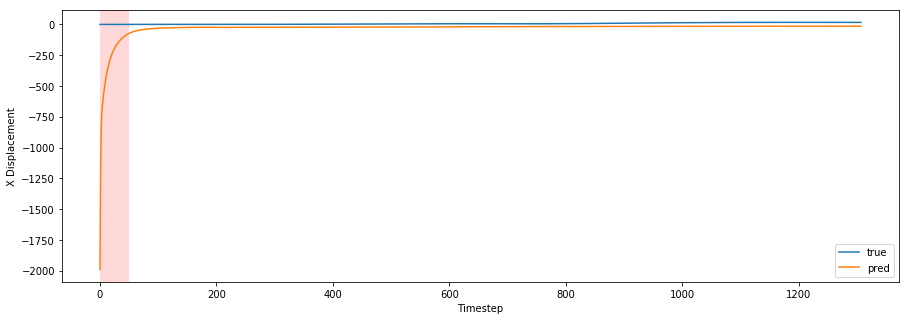

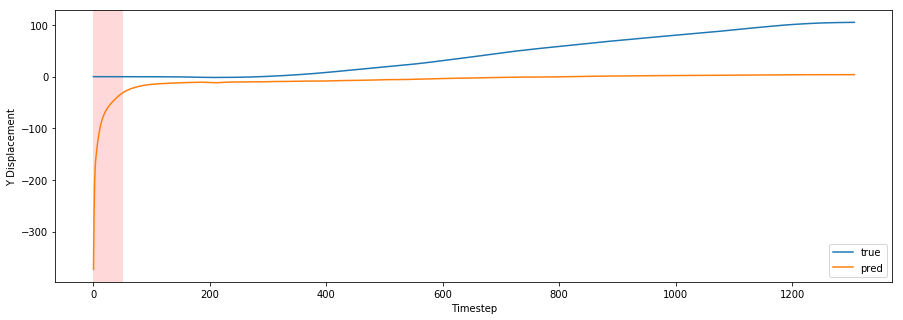

1258


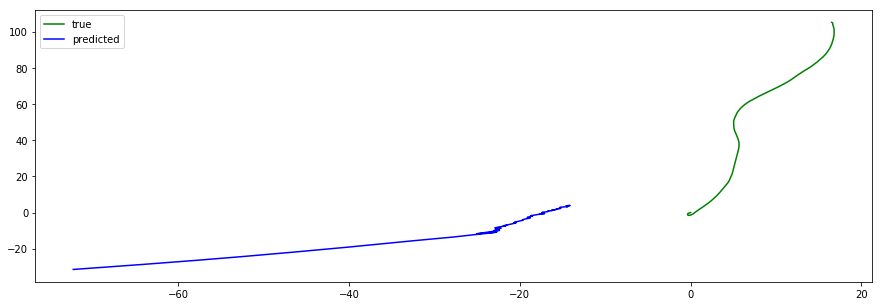

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
Data:  2


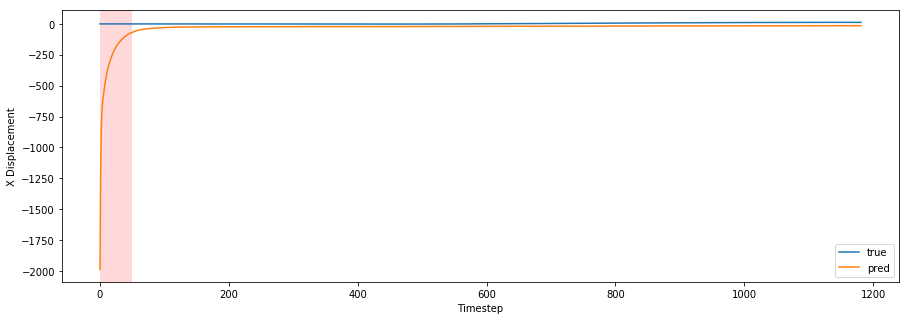

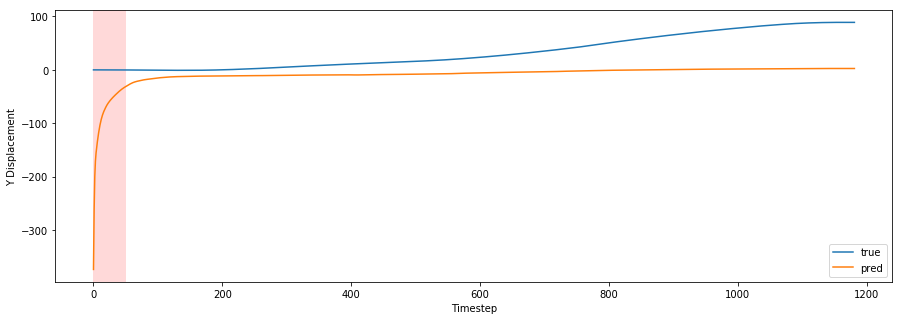

1132


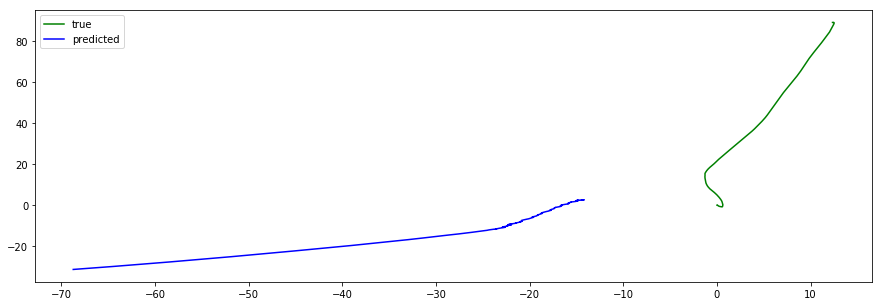

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
Data:  3


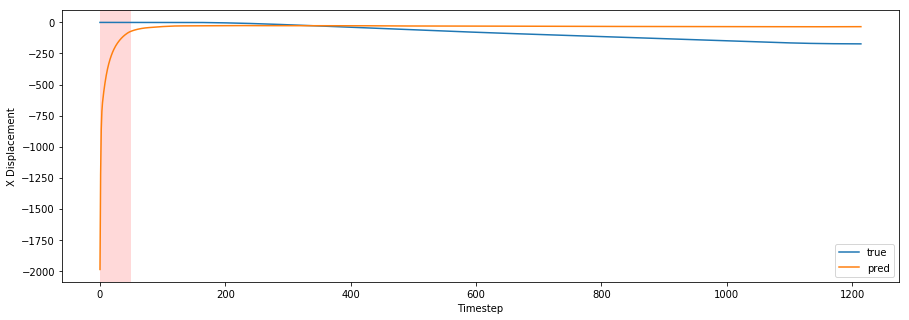

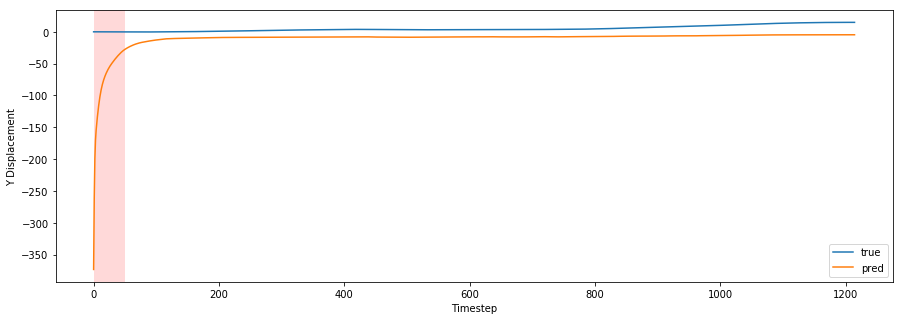

1165


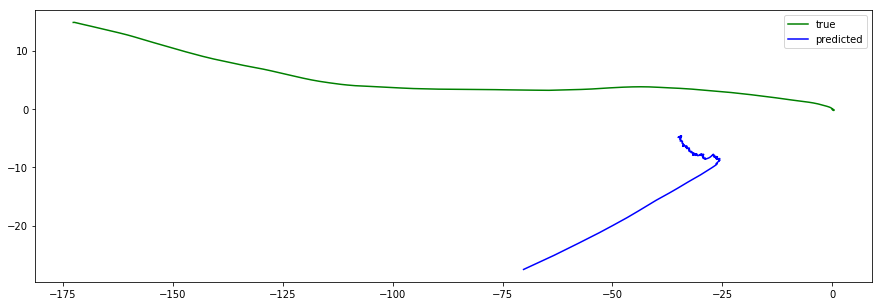

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
Data:  4


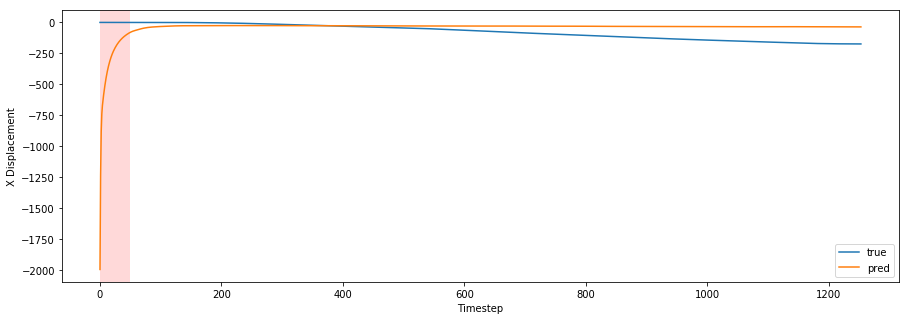

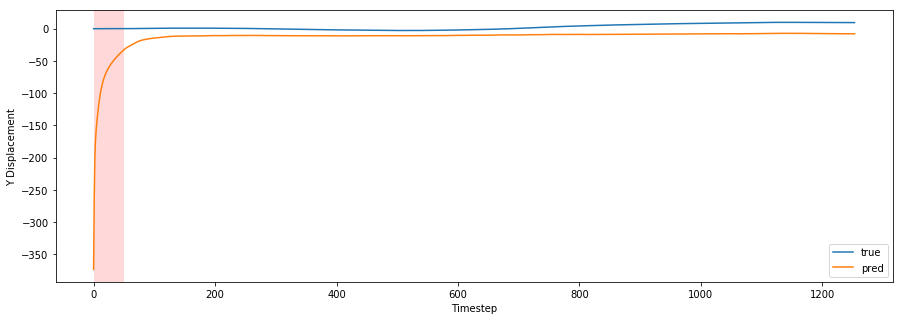

1204


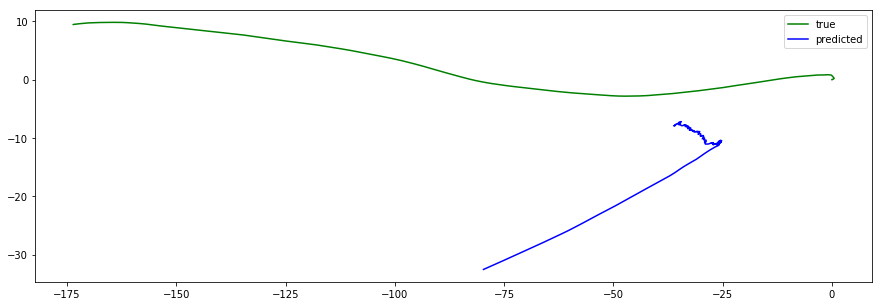

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
Data:  5


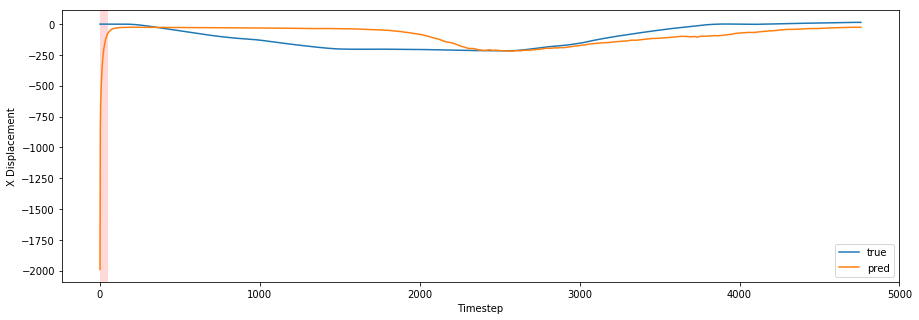

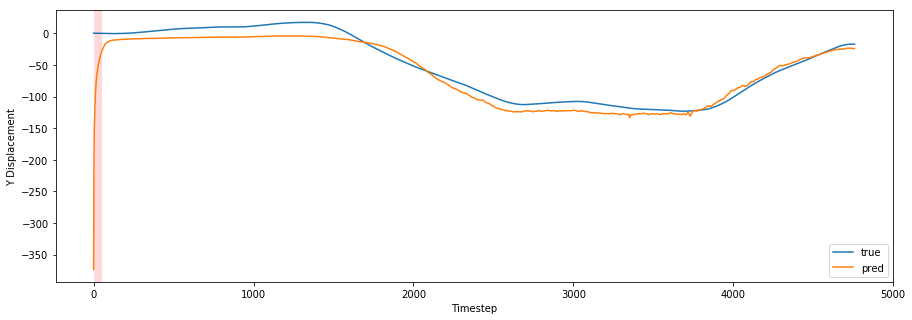

4710


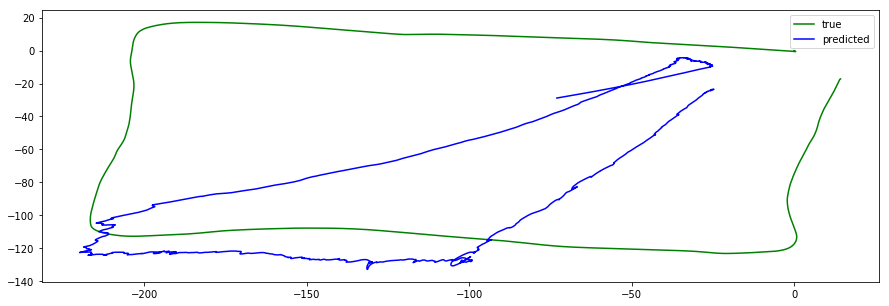

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
Data:  6


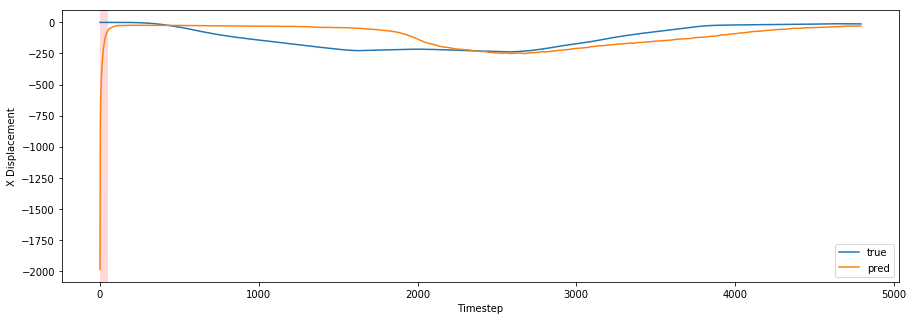

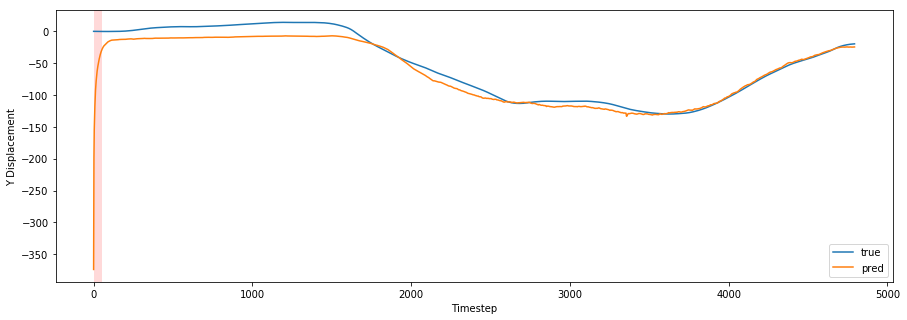

4744


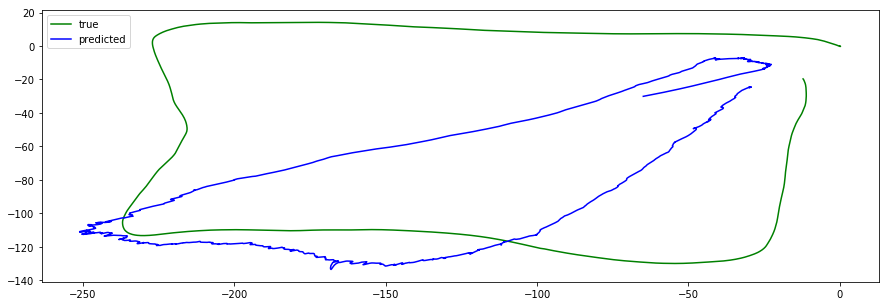

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
Data:  7


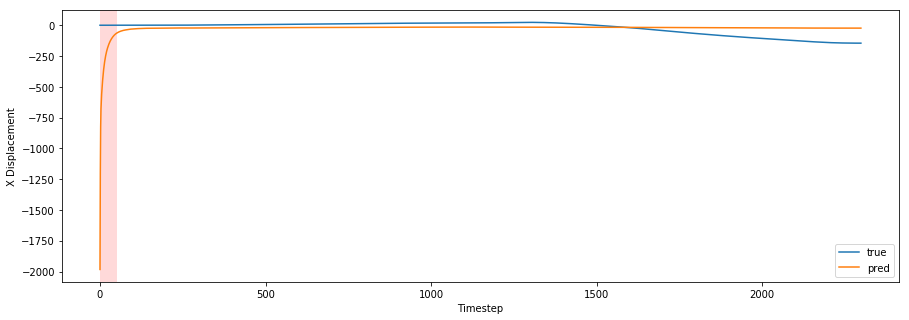

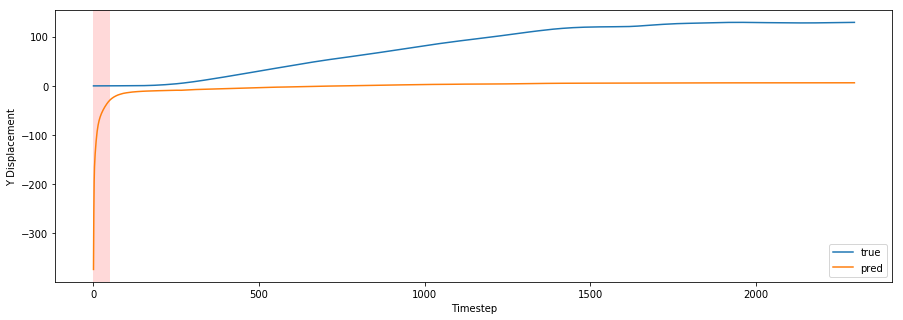

2249


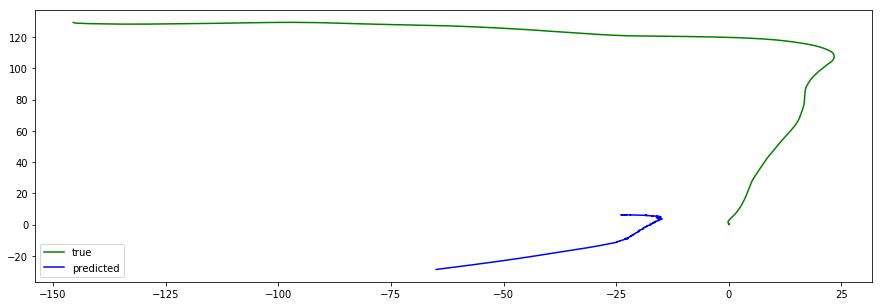

In [26]:

for i in range(1, 8):
    datai = Data_Stream('data'+str(i)+'.csv')
    compute_kalman(datai)
    print("Data: ", i)
    input_datai, ground_truthi = create_input_and_output(datai)
    plot_comparison(input_datai, ground_truthi, start_index=0, length=len(ground_truthi), train=True)
    